# Can we guess football results based on the odds of the bookmakers?

**This notebook is complementary to the article published in Medium "Can we guess football results based on the odds of the bookmakers?".**

https://medium.com/@aczapka/can-we-guess-football-results-based-on-the-odds-of-the-bookmakers-c91846813262

Author: Alberto Czapka, 2022

_This project is under MIT license._

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import catboost
from catboost import Pool
from catboost import CatBoostClassifier

# 1. BUSINESS UNDERSTANDING

Betting on football matches has a long tradition in many countries. We will focus on one of the easiest forms: trying to guess the full time result of the match.

The bookmaker will not reward you the same if you correctly guess the home win compared to the draw or the away win. And this also changes a lot from one match to another.

It turns out that the odds are just the inverse of a probabilistic multi-class prediction. And this prediction of course is not perfect.

- The objective of this project is to analyze this prediction and try to find its weak points. Is it possible to build a better forecasting model based on their data? Is it possible, as a player, to make consistent profits from betting?

# 2. DATA UNDERSTANDING

## Downloading the dataset

Downloading from www.football-data.co.uk the last 20 years of Spanish First Division.

In [2]:
# Downloading data from website.

df_full_dataset = pd.DataFrame()

for i in range(2, 22):
    if i < 9:
        year = f'0{i}0{i + 1}'
    elif i == 9:
        year = f'0{i}{i + 1}'
    else:
        year = f'{i}{i + 1}'
    print(f"\tDownloading season {year}")
    df_read = pd.read_csv(f'https://www.football-data.co.uk/mmz4281/{year}/SP1.csv', on_bad_lines='skip')

    try:
        df_read['Date'] = pd.to_datetime(df_read['Date'], format="%d/%m/%y")
    except ValueError:
        df_read['Date'] = pd.to_datetime(df_read['Date'], format="%d/%m/%Y")
    df_full_dataset = pd.concat([df_full_dataset, df_read])

df_full_dataset.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,SP1,2002-08-31,Santander,Valladolid,0,1,A,0,0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SP1,2002-09-01,Barcelona,Ath Madrid,2,2,D,1,1,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SP1,2002-09-01,La Coruna,Betis,2,4,A,1,3,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SP1,2002-09-01,Mallorca,Valencia,0,2,A,0,1,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SP1,2002-09-01,Recreativo,Malaga,2,3,A,2,1,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploring and cleaning the dataset

In [3]:
# Total number of matches.

len(df_full_dataset)

7488

In [4]:
# Checking which columns have few missing values.

for column in df_full_dataset.isna().mean().iteritems():
    columns_name = column[0]
    column_missing_values = column[1]
    if column_missing_values < 0.05:
        print(columns_name)

Div
Date
HomeTeam
AwayTeam
FTHG
FTAG
FTR
HTHG
HTAG
HTR
B365H
B365D
B365A
IWH
IWD
IWA
WHH
WHD
WHA


Only bookmakers with no missing data in most of the period will be considered.

It turns out they are:
* **B365**: Bet365
* **IW**: Interwetten
* **WH**: William Hill

In [5]:
# Keep only columns with almost no missing data.

df = df_full_dataset[df_full_dataset.columns[df_full_dataset.isna().mean() < 0.02]].copy()
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,B365H,B365D,B365A,IWH,IWD,IWA,WHH,WHD,WHA
0,SP1,2002-08-31,Santander,Valladolid,0,1,A,0,0,D,1.909,3.25,3.40,2.10,3.0,3.1,2.00,3.1,3.30
1,SP1,2002-09-01,Barcelona,Ath Madrid,2,2,D,1,1,D,1.500,3.40,6.00,1.55,3.5,4.8,1.53,3.4,5.50
2,SP1,2002-09-01,La Coruna,Betis,2,4,A,1,3,A,1.500,3.40,6.00,1.50,3.7,5.0,1.53,3.4,5.50
3,SP1,2002-09-01,Mallorca,Valencia,0,2,A,0,1,A,2.875,3.00,2.25,2.50,3.0,2.5,2.62,3.1,2.37
4,SP1,2002-09-01,Recreativo,Malaga,2,3,A,2,1,H,2.500,3.10,2.50,2.30,3.0,2.7,2.30,3.1,2.75


**Relevant columns explained:**
- **FTHG, FTAG**: Full time home/away goals.
- **FTR**: Full time result ("H" for home, "D" for draw and "A" for away).
- **HTHG, HTAG**: Half time home/away goals.
- **HTR**: Half time result.
- **B365H, B365D, B365A**: Bet365 bookmaker odds home/draw/away.
- **IWH, IWD, IWA**: Interwetten bookmaker odds home/draw/away.
- **WHH, WHD, WHA**: Willian Hill bookmaker odds home/draw/away.

Keep in mind that "odds" are the inverse of the probabilist prediction.

In [6]:
# Categorical predictions for each of the selected bookmakers.

all_predictions = []

for row in df.iterrows():
    match_predictions = []

    for bookhouse in ['B365', 'IW', 'WH']:
        if row[1][bookhouse + 'H'] <= min(row[1][bookhouse + 'D'], row[1][bookhouse + 'A']):
            predicted_result = 'H'
        elif row[1][bookhouse + 'D'] <= min(row[1][bookhouse + 'H'], row[1][bookhouse + 'A']):
            predicted_result = 'D'
        elif row[1][bookhouse + 'A'] <= min(row[1][bookhouse + 'H'], row[1][bookhouse + 'D']):
            predicted_result = 'A'
        else:
            predicted_result = np.nan

        match_predictions.append(predicted_result)
    all_predictions.append(match_predictions)

df = pd.concat([df.reset_index(), pd.DataFrame(data=all_predictions, columns=['B365R', 'IWR', 'WHR'])], axis=1)
df = df[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'B365H', 'B365D', 'B365A', 'B365R', 'IWH', 'IWD', 'IWA',
         'IWR', 'WHH', 'WHD', 'WHA', 'WHR']]
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,B365R,IWH,IWD,IWA,IWR,WHH,WHD,WHA,WHR
0,2002-08-31,Santander,Valladolid,0,1,A,1.909,3.25,3.40,H,2.10,3.0,3.1,H,2.00,3.1,3.30,H
1,2002-09-01,Barcelona,Ath Madrid,2,2,D,1.500,3.40,6.00,H,1.55,3.5,4.8,H,1.53,3.4,5.50,H
2,2002-09-01,La Coruna,Betis,2,4,A,1.500,3.40,6.00,H,1.50,3.7,5.0,H,1.53,3.4,5.50,H
3,2002-09-01,Mallorca,Valencia,0,2,A,2.875,3.00,2.25,A,2.50,3.0,2.5,H,2.62,3.1,2.37,A
4,2002-09-01,Recreativo,Malaga,2,3,A,2.500,3.10,2.50,H,2.30,3.0,2.7,H,2.30,3.1,2.75,H


In [7]:
# Checking final number of missing values.

df.isna().mean()

Date        0.000000
HomeTeam    0.000000
AwayTeam    0.000000
FTHG        0.000000
FTAG        0.000000
FTR         0.000000
B365H       0.000801
B365D       0.000801
B365A       0.000801
B365R       0.000801
IWH         0.001736
IWD         0.001736
IWA         0.001736
IWR         0.001736
WHH         0.013622
WHD         0.013622
WHA         0.013622
WHR         0.013622
dtype: float64

In [8]:
# Dropping the few rows with missing values.

df = df.dropna().copy()
len(df)

7370

## QUESTION: How often do the home and away teams win?

In [9]:
# How many home wins, away wins and draws are there in the dataset?

df['FTR'].value_counts() / len(df)

H    0.468928
A    0.280326
D    0.250746
Name: FTR, dtype: float64

[Text(0.5, 1.0, 'Cumulative histogram of "full time home goals"')]

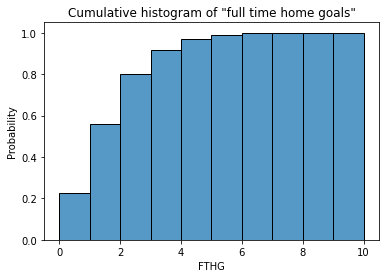

In [10]:
# Histogram of full time home goals.

sns.histplot(data=df, x='FTHG', binwidth=1, stat='probability', cumulative=True).set(title='Cumulative histogram of "full time home goals"')

[Text(0.5, 1.0, 'Cumulative histogram of "full time away goals"')]

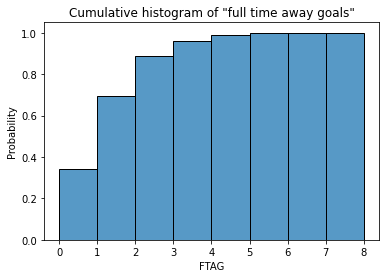

In [11]:
# Histogram of full time away goals.

sns.histplot(data=df, x='FTAG', binwidth=1, stat='probability', cumulative=True).set(title='Cumulative histogram of "full time away goals"')

[Text(0.5, 1.0, 'Correlation between full time home and away goals')]

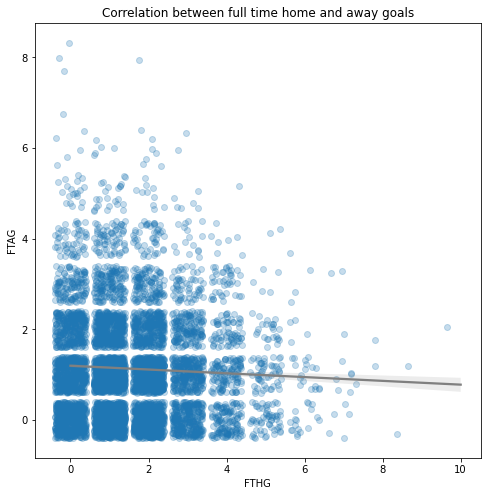

In [12]:
# Correlation between home and away goals.

plt.figure(figsize=(8,8))
sns.regplot(
    x='FTHG', 
    y='FTAG', 
    data=df, 
    order=1, 
    scatter_kws=dict(alpha=0.25), 
    line_kws=dict(color='gray'),
    x_jitter=0.4,
    y_jitter=0.4,
).set(title='Correlation between full time home and away goals')

## QUESTION: Are the odds of different bookmakers similar?

In [13]:
# Checking when the three bookmakers give the same prediction and when one of them (Bet365) is true.

df['is_bookmaker_R_equal'] = ((df['B365R']==df['IWR']) & (df['B365R']==df['WHR']))
df['is_B365_R_true'] = (df['B365R']==df['FTR'])
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,B365R,IWH,IWD,IWA,IWR,WHH,WHD,WHA,WHR,is_bookmaker_R_equal,is_B365_R_true
0,2002-08-31,Santander,Valladolid,0,1,A,1.909,3.25,3.40,H,2.10,3.0,3.1,H,2.00,3.1,3.30,H,True,False
1,2002-09-01,Barcelona,Ath Madrid,2,2,D,1.500,3.40,6.00,H,1.55,3.5,4.8,H,1.53,3.4,5.50,H,True,False
2,2002-09-01,La Coruna,Betis,2,4,A,1.500,3.40,6.00,H,1.50,3.7,5.0,H,1.53,3.4,5.50,H,True,False
3,2002-09-01,Mallorca,Valencia,0,2,A,2.875,3.00,2.25,A,2.50,3.0,2.5,H,2.62,3.1,2.37,A,False,True
4,2002-09-01,Recreativo,Malaga,2,3,A,2.500,3.10,2.50,H,2.30,3.0,2.7,H,2.30,3.1,2.75,H,True,False


In [14]:
# On average, their categorical predictions are about the same. The accuracy is around 53 %.

df[['is_bookmaker_R_equal', 'is_B365_R_true']].mean()

is_bookmaker_R_equal    0.964993
is_B365_R_true          0.532836
dtype: float64

In [15]:
# Correlation between the odds of the bookmakers.

for result in ['H', 'D', 'A']:
    print(df[['IW'+result, 'WH'+result, 'B365'+result]].corr())

            IWH       WHH     B365H
IWH    1.000000  0.979050  0.978881
WHH    0.979050  1.000000  0.988416
B365H  0.978881  0.988416  1.000000
            IWD       WHD     B365D
IWD    1.000000  0.957989  0.959169
WHD    0.957989  1.000000  0.970524
B365D  0.959169  0.970524  1.000000
            IWA       WHA     B365A
IWA    1.000000  0.959632  0.963983
WHA    0.959632  1.000000  0.971593
B365A  0.963983  0.971593  1.000000


[Text(0.5, 1.0, 'Histogram of all the odds of Bet365')]

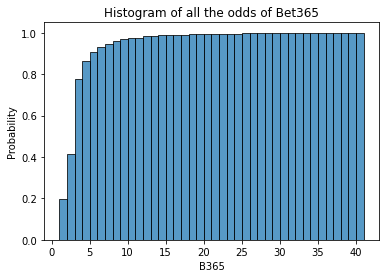

In [16]:
# Histogram of all the odds of Bet365.

all_odds_interwetten = np.concatenate((df['IWH'].values, df['IWD'].values, df['IWA'].values))
all_odds_willian_hill = np.concatenate((df['WHH'].values, df['WHD'].values, df['WHA'].values))
all_odds_bet365 = np.concatenate((df['B365H'].values, df['B365D'].values, df['B365A'].values))
df_all_odds = pd.DataFrame(data=np.array([all_odds_interwetten, all_odds_willian_hill, all_odds_bet365]).T, columns=['IW', 'WH', 'B365'])

sns.histplot(data=df_all_odds, x='B365', binwidth=1, stat='probability', cumulative=True).set(title='Histogram of all the odds of Bet365')

array([[<AxesSubplot:xlabel='IW', ylabel='IW'>,
        <AxesSubplot:xlabel='WH', ylabel='IW'>,
        <AxesSubplot:xlabel='B365', ylabel='IW'>],
       [<AxesSubplot:xlabel='IW', ylabel='WH'>,
        <AxesSubplot:xlabel='WH', ylabel='WH'>,
        <AxesSubplot:xlabel='B365', ylabel='WH'>],
       [<AxesSubplot:xlabel='IW', ylabel='B365'>,
        <AxesSubplot:xlabel='WH', ylabel='B365'>,
        <AxesSubplot:xlabel='B365', ylabel='B365'>]], dtype=object)

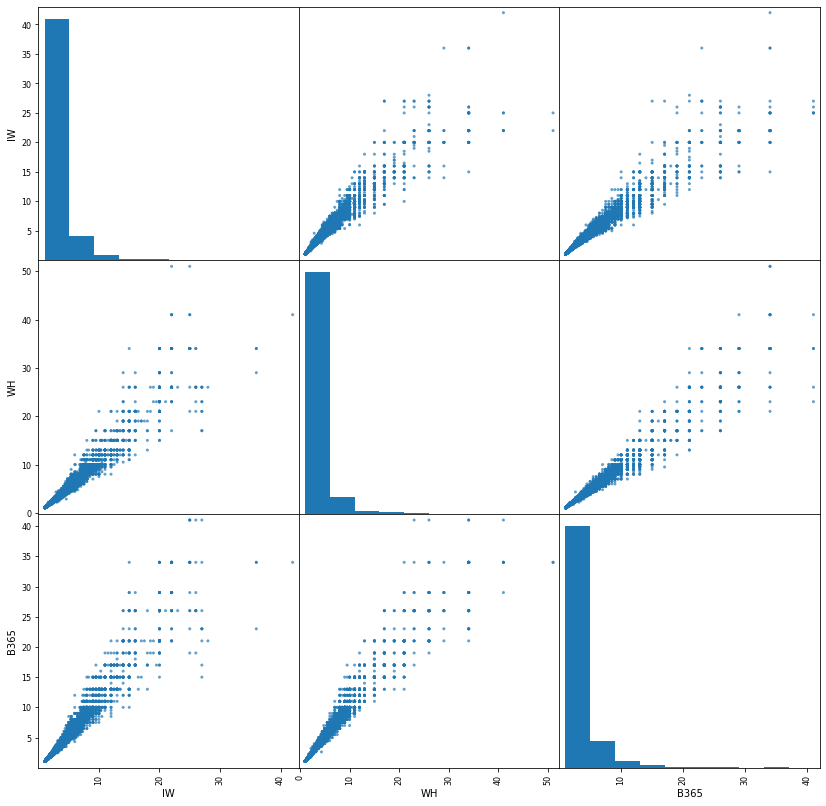

In [17]:
# Correlation plot between the odds of the bookmakers.

pd.plotting.scatter_matrix(df_all_odds, alpha=.7, figsize=(14, 14))

array([[<AxesSubplot:xlabel='IW', ylabel='IW'>,
        <AxesSubplot:xlabel='WH', ylabel='IW'>,
        <AxesSubplot:xlabel='B365', ylabel='IW'>],
       [<AxesSubplot:xlabel='IW', ylabel='WH'>,
        <AxesSubplot:xlabel='WH', ylabel='WH'>,
        <AxesSubplot:xlabel='B365', ylabel='WH'>],
       [<AxesSubplot:xlabel='IW', ylabel='B365'>,
        <AxesSubplot:xlabel='WH', ylabel='B365'>,
        <AxesSubplot:xlabel='B365', ylabel='B365'>]], dtype=object)

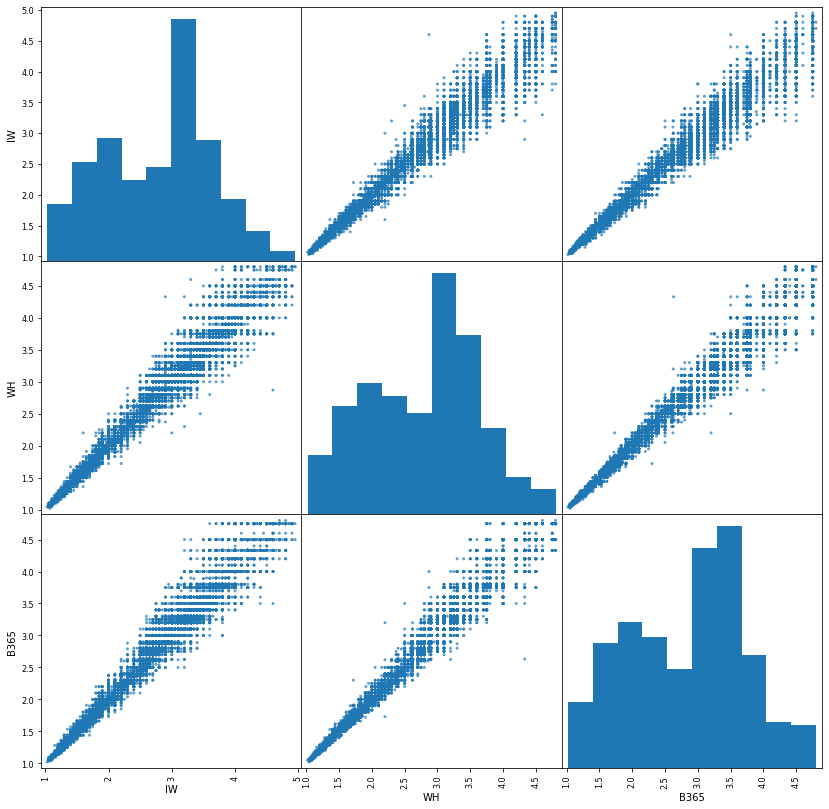

In [18]:
# Correlation plot between the odds of the bookmakers (without extremely high values, only odds below 5).

pd.plotting.scatter_matrix(df_all_odds[df_all_odds.max(axis=1) < 5], alpha=.7, figsize=(14, 14))

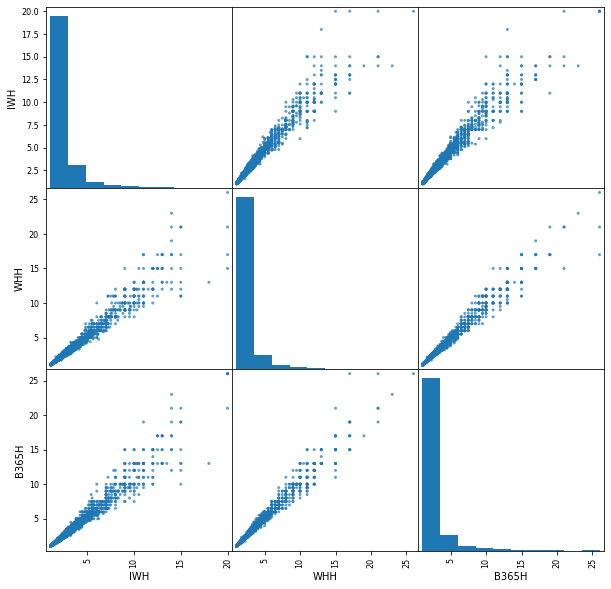

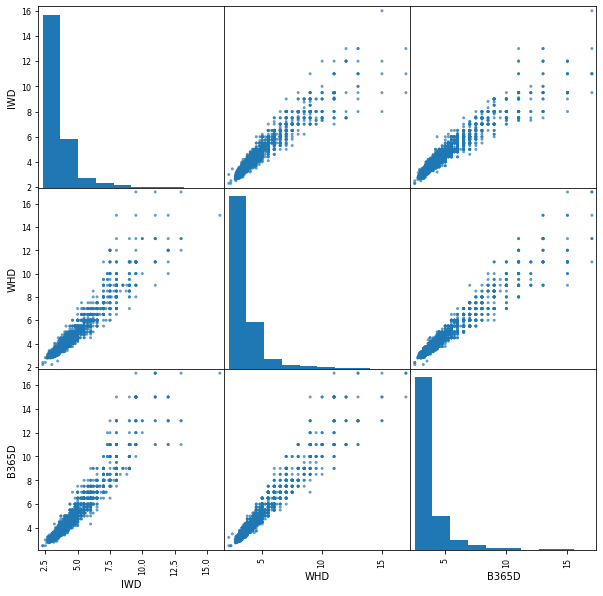

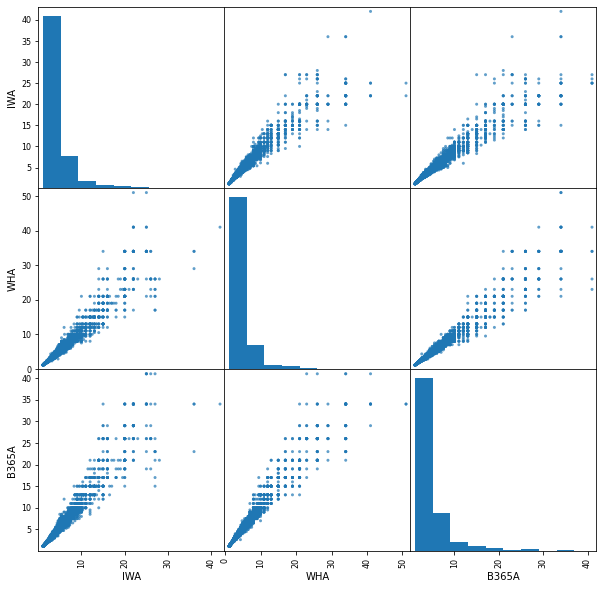

In [19]:
# Correlation plot between the odds of the bookmakers (for each result).

for result in ['H', 'D', 'A']:
    pd.plotting.scatter_matrix(df[['IW' + result, 'WH' + result, 'B365' + result]], alpha=.7, figsize=(10, 10))

# 3. DATA PREPARATION

## Choosing one bookmaker

As we saw in the previous sections, we can focus on just one bookmaker and the results should not vary much.

From now one, we will use data of **Bet365** because they have the least missing data:
- B365H: Home odds.
- B365D: Draw odds. 
- B365A: Away odds.
- B365R: Full time result categorical prediction.


## QUESTION: How accurate are the predictions of the bookmakers?

In [20]:
# Average accuracy.

df['is_B365_R_true'].mean()

0.5328358208955224

Text(0.5, 15.0, 'Predicted label')

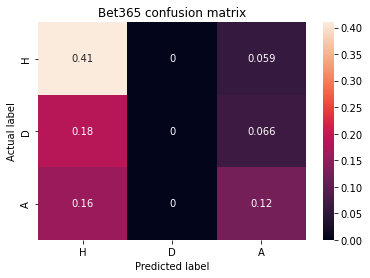

In [21]:
# Confusion matrix.

bookmaker_confusion_matrix = confusion_matrix(y_true=df['FTR'], y_pred=df['B365R'], labels=['H', 'D', 'A'], normalize='all') 
bookmaker_confusion_matrix = pd.DataFrame(data=bookmaker_confusion_matrix, columns=['H', 'D', 'A'], index=['H', 'D', 'A'])

sns.heatmap(bookmaker_confusion_matrix, annot=True)
plt.title('Bet365 confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## QUESTION: Have the predictions of the bookmakers changed over time?

In [22]:
# A season has around 380 matches: rolling average of two seasons.

df['is_B365_R_true_average'] = df['is_B365_R_true'].rolling(380 * 2).mean()

(12348.9, 19457.1, 0.0, 1.0)

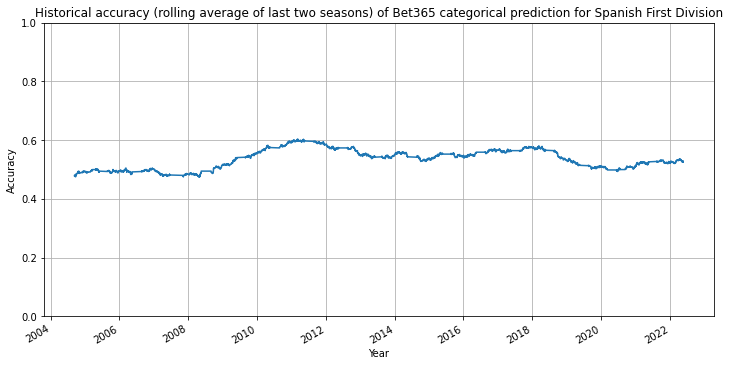

In [23]:
# Accuracy historical plot.

df.set_index('Date')['is_B365_R_true_average'].plot(
    figsize=(12, 6), 
    title='Historical accuracy (rolling average of last two seasons) of Bet365 categorical prediction for Spanish First Division', 
    xlabel ="Year", 
    ylabel="Accuracy", 
    grid=True,
).axis([None, None, 0, 1])

(12348.9, 19457.1, 0.0, 1.2)

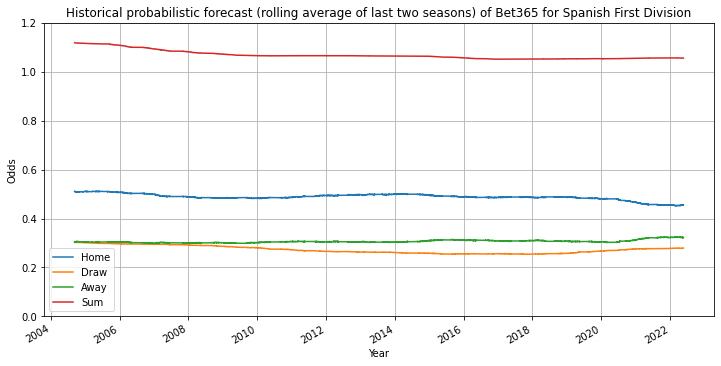

In [24]:
# Probabilty historical plot.

df_plot = df.copy()

df_plot['Home'] = 1 / df_plot['B365H']
df_plot['Draw'] = 1 / df_plot['B365D']
df_plot['Away'] = 1 / df_plot['B365A']
df_plot['Sum'] = df_plot['Home'] + df_plot['Draw'] + df_plot['Away']

df_plot['Home'] = df_plot['Home'].rolling(380 * 2).mean()
df_plot['Draw'] = df_plot['Draw'].rolling(380 * 2).mean()
df_plot['Away'] = df_plot['Away'].rolling(380 * 2).mean()
df_plot['Sum'] = df_plot['Sum'].rolling(380 * 2).mean()

df_plot.set_index('Date')[['Home', 'Draw', 'Away', 'Sum']].plot(
    figsize=(12, 6),
    title='Historical probabilistic forecast (rolling average of last two seasons) of Bet365 for Spanish First Division',
    xlabel="Year",
    ylabel="Odds",
    grid=True,
).axis([None, None, 0, 1.2])

# 4. MODELING

We will try forecasting match results trying to achieve a profitable betting strategy.

## Naive strategy

In [25]:
# Let's try some really simple strategies and see what happens.

def naive_strategy_bet(strategy, odds_home, odds_draw, odds_away):
    """Generates one bet for one particular match according to a naive strategy"""

    bet = None
    if strategy == 'always_home':
        bet = 'H'
    elif strategy == 'always_draw':
        bet = 'D'
    elif strategy == 'always_away':
        bet = 'A'
    elif strategy == 'highest_odds':
        if odds_home >= odds_draw and odds_home >= odds_away:
            bet = 'H'
        elif odds_draw >= odds_home and odds_draw >= odds_away:
            bet = 'D'
        else:
            bet = 'A'
    elif strategy == 'intermediate_odds':
        if odds_away >= odds_home >= odds_draw or odds_draw >= odds_home >= odds_away:
            bet = 'H'
        elif odds_home >= odds_draw >= odds_away or odds_away >= odds_draw >= odds_home:
            bet = 'D'
        else:
            bet = 'A'
    elif strategy == 'lowest_odds':
        if odds_home <= odds_draw and odds_home <= odds_away:
            bet = 'H'
        elif odds_draw <= odds_home and odds_draw <= odds_away:
            bet = 'D'
        else:
            bet = 'A'
    elif strategy == 'random':
        bet = np.random.choice(['H', 'D', 'A'])
    return bet

## Catboost classifier (multi-class)

In [26]:
# Trying catboost, only using odds as predictors.

labels_catboost_odds = df[['FTR']]
features_catboost_odds = df[['B365H', 'B365D', 'B365A']]

features_train_catboost_odds, features_validation_catboost_odds, labels_train_catboost_odds, labels_validation_catboost_odds = train_test_split(
    features_catboost_odds,
    labels_catboost_odds,
    test_size=0.2,
    random_state=0,
)
train_pool_catboost_odds = Pool(
    data=features_train_catboost_odds,
    label=labels_train_catboost_odds,
)
validation_pool_catboost_odds = Pool(
    data=features_validation_catboost_odds,
    label=labels_validation_catboost_odds,
)
model_catboost_odds = CatBoostClassifier()
model_catboost_odds.fit(
    train_pool_catboost_odds,
    eval_set=validation_pool_catboost_odds,
    verbose=100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.111877
0:	learn: 1.0719855	test: 1.0722937	best: 1.0722937 (0)	total: 50.2ms	remaining: 50.2s
100:	learn: 0.9511405	test: 0.9750233	best: 0.9710407 (44)	total: 254ms	remaining: 2.26s
200:	learn: 0.9277257	test: 0.9821977	best: 0.9710407 (44)	total: 453ms	remaining: 1.8s
300:	learn: 0.9101448	test: 0.9884397	best: 0.9710407 (44)	total: 653ms	remaining: 1.51s
400:	learn: 0.8973103	test: 0.9944663	best: 0.9710407 (44)	total: 841ms	remaining: 1.26s
500:	learn: 0.8858432	test: 1.0004980	best: 0.9710407 (44)	total: 1.06s	remaining: 1.05s
600:	learn: 0.8754784	test: 1.0054503	best: 0.9710407 (44)	total: 1.29s	remaining: 857ms
700:	learn: 0.8666910	test: 1.0112915	best: 0.9710407 (44)	total: 1.48s	remaining: 630ms
800:	learn: 0.8595109	test: 1.0150370	best: 0.9710407 (44)	total: 1.66s	remaining: 413ms
900:	learn: 0.8530949	test: 1.0200400	best: 0.9710407 (44)	total: 1.89s	remaining: 208ms
999:	learn: 0.8470482	test: 1.0241145	best: 0.9710407 (44)	total: 2.11s	remaining: 

In [27]:
# Predicting validation dataset.

predictions_catboost_odds = model_catboost_odds.predict(validation_pool_catboost_odds).flatten()

In [28]:
# Trying catboost, using odds and team names as predictors.

labels_catboost_odds_teams = df[['FTR']]
features_catboost_odds_teams = df[['B365H', 'B365D', 'B365A', 'HomeTeam', 'AwayTeam']]
categorical_features_catboost_odds_teams = ['HomeTeam', 'AwayTeam']

features_train_catboost_odds_teams, features_validation_catboost_odds_teams, labels_train_catboost_odds_teams, labels_validation_catboost_odds_teams = train_test_split(
    features_catboost_odds_teams,
    labels_catboost_odds_teams,
    test_size=0.2,
    random_state=0,
)
train_pool_catboost_odds_teams = Pool(
    data=features_train_catboost_odds_teams,
    label=labels_train_catboost_odds_teams,
    cat_features=categorical_features_catboost_odds_teams
)
validation_pool_catboost_odds_teams = Pool(
    data=features_validation_catboost_odds_teams,
    label=labels_validation_catboost_odds_teams,
    cat_features=categorical_features_catboost_odds_teams
)
model_catboost_odds_teams = CatBoostClassifier()
model_catboost_odds_teams.fit(
    train_pool_catboost_odds_teams,
    eval_set=validation_pool_catboost_odds_teams,
    verbose=100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.111877
0:	learn: 1.0712451	test: 1.0723050	best: 1.0723050 (0)	total: 12.1ms	remaining: 12s
100:	learn: 0.9148222	test: 0.9754422	best: 0.9714195 (45)	total: 447ms	remaining: 3.98s
200:	learn: 0.8602582	test: 0.9811661	best: 0.9714195 (45)	total: 798ms	remaining: 3.17s
300:	learn: 0.8151516	test: 0.9863140	best: 0.9714195 (45)	total: 1.17s	remaining: 2.71s
400:	learn: 0.7735182	test: 0.9880108	best: 0.9714195 (45)	total: 1.54s	remaining: 2.31s
500:	learn: 0.7357596	test: 0.9956066	best: 0.9714195 (45)	total: 1.96s	remaining: 1.95s
600:	learn: 0.6998997	test: 0.9991257	best: 0.9714195 (45)	total: 2.34s	remaining: 1.55s
700:	learn: 0.6664582	test: 1.0037935	best: 0.9714195 (45)	total: 2.79s	remaining: 1.19s
800:	learn: 0.6360301	test: 1.0105220	best: 0.9714195 (45)	total: 3.23s	remaining: 802ms
900:	learn: 0.6058282	test: 1.0157195	best: 0.9714195 (45)	total: 3.6s	remaining: 396ms
999:	learn: 0.5793444	test: 1.0204653	best: 0.9714195 (45)	total: 4.03s	remaining: 0u

In [29]:
# Predicting validation dataset.

predictions_catboost_odds_teams = model_catboost_odds_teams.predict(validation_pool_catboost_odds_teams).flatten()

## Logistic regression (binary classification of draws)

In [30]:
# Let's try binary classifying if a match is a draw or not.

df['FTR_is_draw'] = 0
df.loc[df['FTR'] == 'D', 'FTR_is_draw'] = 1

In [31]:
# Logistic regression.

labels_logistic_reg = df[['FTR', 'FTR_is_draw']]
features_logistic_reg = df[['B365H', 'B365D', 'B365A']]

features_train_logistic_reg, features_validation_logistic_reg, labels_train_logistic_reg, labels_validation_logistic_reg = train_test_split(
    features_logistic_reg,
    labels_logistic_reg,
    test_size=0.2,
    random_state=0,
)
observations_logistic_reg = labels_validation_logistic_reg[['FTR']].values.flatten()
clf = LogisticRegression(random_state=0).fit(
    X=features_train_logistic_reg,
    y=labels_train_logistic_reg[['FTR_is_draw']].values.flatten(),
)

In [32]:
# Predicting validation dataset.

predictions_logistic_reg = clf.predict(features_validation_logistic_reg)
predictions_logistic_reg = np.array(['D' if prediction==1 else None for prediction in predictions_logistic_reg])

# 5. EVALUATION

## Evaluation metric

The choosen metrics are the accuracy and return on investment (ROI).

In [33]:
# This function will calculate if the following strategies and models are profitable.

def calculate_roi_and_accuracy(observations, predictions, odds_home, odds_draw, odds_away, money_each_bet=100):
    """Calculates the return on investment (ROI) and accuracy of applying a certain betting sequence"""

    profits = 0
    investments = 0
    true_counter = 0

    for i, match in enumerate(observations):
        if predictions[i] is None:
            continue
        investments += money_each_bet

        earned_money_this_match = 0
        if observations[i] == predictions[i]:
            true_counter += 1
            if observations[i] == 'H':
                earned_money_this_match = money_each_bet * odds_home[i]
            elif observations[i] == 'D':
                earned_money_this_match = money_each_bet * odds_draw[i]
            elif observations[i] == 'A':
                earned_money_this_match = money_each_bet * odds_away[i]
        profits = profits + earned_money_this_match - money_each_bet

    try:
        return_over_investment = profits / investments * 100
        return_over_investment = round(return_over_investment, 1)
    except ZeroDivisionError:
        return_over_investment = round(0, 1)

    accuracy = true_counter / len(observations) * 100
    accuracy = round(accuracy, 1)

    return return_over_investment, accuracy

## QUESTION: Are the odds of the bookmakers properly estimated?

### Naive strategy

In [34]:
for strategy in ['random', 'always_home', 'always_draw', 'always_away', 'highest_odds', 'intermediate_odds',
                 'lowest_odds']:
    bets = []
    results = []
    for match in df.itertuples():
        odds_home = match.B365H
        odds_draw = match.B365D
        odds_away = match.B365A
        result = match.FTR

        bet = naive_strategy_bet(strategy, odds_home, odds_draw, odds_away)
        bets.append(bet)
        results.append(result)

    roi, accuracy = calculate_roi_and_accuracy(
        observations=results,
        predictions=bets,
        odds_home=df['B365H'].values,
        odds_draw=df['B365D'].values,
        odds_away=df['B365A'].values,
    )
    print(f"For the '{strategy}' strategy the accuracy is {accuracy} % and the return on investment is {roi} %.")

For the 'random' strategy the accuracy is 33.2 % and the return on investment is -7.1 %.
For the 'always_home' strategy the accuracy is 46.9 % and the return on investment is -4.0 %.
For the 'always_draw' strategy the accuracy is 25.1 % and the return on investment is -9.7 %.
For the 'always_away' strategy the accuracy is 28.0 % and the return on investment is -10.1 %.
For the 'highest_odds' strategy the accuracy is 21.6 % and the return on investment is -7.0 %.
For the 'intermediate_odds' strategy the accuracy is 25.1 % and the return on investment is -12.5 %.
For the 'lowest_odds' strategy the accuracy is 53.3 % and the return on investment is -4.4 %.


### Catboost

In [35]:
# Only using odds as predictors.
# Results on validation dataset.

roi, accuracy = calculate_roi_and_accuracy(
    observations=labels_validation_catboost_odds.values.flatten(), 
    predictions=predictions_catboost_odds, 
    odds_home=features_validation_catboost_odds['B365H'].values, 
    odds_draw=features_validation_catboost_odds['B365D'].values, 
    odds_away=features_validation_catboost_odds['B365A'].values
)
print(f"For the catboost model (only odds as features) the accuracy is {accuracy} % and the return on investment is {roi} %.")

For the catboost model (only odds as features) the accuracy is 52.8 % and the return on investment is -4.9 %.


In [36]:
# Using odds and team names as predictors.
# Results on validation dataset.

roi, accuracy = calculate_roi_and_accuracy(
    observations=labels_validation_catboost_odds_teams.values.flatten(), 
    predictions=predictions_catboost_odds_teams, 
    odds_home=features_validation_catboost_odds_teams['B365H'].values, 
    odds_draw=features_validation_catboost_odds_teams['B365D'].values, 
    odds_away=features_validation_catboost_odds_teams['B365A'].values
)
print(f"For the catboost model (odds and team names as features) the accuracy is {accuracy} % and the return on investment is {roi} %.")

For the catboost model (odds and team names as features) the accuracy is 52.3 % and the return on investment is -6.1 %.


### Logistic regression

In [37]:
# Results on validation dataset.

accuracy = round(clf.score(X=features_validation_logistic_reg, y=labels_validation_logistic_reg[['FTR_is_draw']].values.flatten()) * 100, 2)
print(f"The accuracy on validation dataset is {accuracy} % but this is because the regression predicted {clf.predict(features_validation_logistic_reg).sum()} draws in total.")

The accuracy on validation dataset is 74.97 % but this is because the regression predicted 0 draws in total.


In [38]:
# Results on validation dataset.

roi, accuracy = calculate_roi_and_accuracy(
    observations=observations_logistic_reg, 
    predictions=predictions_logistic_reg, 
    odds_home=features_validation_logistic_reg['B365H'].values, 
    odds_draw=features_validation_logistic_reg['B365D'].values, 
    odds_away=features_validation_logistic_reg['B365A'].values
)
print(f"For the logistic regression (binary classification of draws) the accuracy is {accuracy} % and the return on investment of {roi} %.")

For the logistic regression (binary classification of draws) the accuracy is 0.0 % and the return on investment of 0 %.


# 6. CONCLUSION AND DEPLOYMENT

As a bookmaker, you need some probabilistic predictions to set up odds before the match. This forecast does not need to be perfect. Despite the fact that its accuracy is "only" 50–60 % and even having an obvious problem of underestimating the draw probability, it is good enough. 

As a player, if you only had this information, it seems that you would have no choice but to lose money in the long run. But maybe is it possible to build a more refined model including additional data.

The ideas and models tried in this notebook has been further developed in a bigger project: 

https://github.com/aczapka/football-predictions 

Do not hesitate to check it.

Author: Alberto Czapka, 2022

_This project is under MIT license._